#  Прогнозирование заказов такси
**Описание проекта**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<span style='color:blue'> +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ </span>

# Оглавление

<span style='color:blue'> +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ </span>

## Цели и задачи проекта

[К оглавлению](#Оглавление)

В рамках работы над проектом должны быть достигнуты следующие цели:

- Чтобы привлекать водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

Для достижения целей проекта должны быть выполнены следующие задачи:

1. Исследовать общую информация о данных:
    - `taxi.csv`
2. Выполнить предобработку данных:
    - Обработка пропущенных значений
    - Изменение типов данных
    - Выявление и обработка аномальных значений
3. Загрузить данные и выполнить их ресемплирование по одному часу.
4. Проанализировать данные.
5. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
6. Проверить данные на тестовой выборке и сделать выводы.
7. Оформить общий вывод

Исходные данные:
- Данные лежат в файле `taxi.csv`.
- Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<span style='color:blue'> +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ </span>

## Импорт библиотек, загрузка данных, константы

[К оглавлению](#Оглавление)

Установка библиотек

In [1]:
!pip install -q -U scikit-learn

Импорт библиотек

In [2]:
#библиотека для работы с данными 
import pandas as pd

#библиотека для работы с регулярными выражениями
import re

#библиотека для вывода данных
from IPython.display import display

#библотеки для графиков
import seaborn as sns

#библиотека для подсчета времени выполнения команд
import time

#настройки seaborn
sns.set(style = 'darkgrid') 
sns.set(rc={'figure.figsize': (15, 6)}) 
sns.set_context('notebook', rc={'font.size': 10, 
                                'axes.titlesize': 10, 
                                'axes.labelsize': 10, 
                                'xtick.labelsize': 'small', 
                                'ytick.labelsize': 'small', 
                                'legend.fontsize': 'small', 
                                'legend.title_fontsize': 10})

import matplotlib.pyplot as plt

from scipy import stats as st

from sklearn.model_selection import train_test_split 

#математические библиотеки
import numpy as np

#метрики
from sklearn.metrics import root_mean_squared_error

#разделение данных, кросс-валидация с пользовательской метрикой
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

# загружаем нужные модели
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor 
from sklearn.linear_model import LinearRegression

# импортируем классы поиска
from sklearn.model_selection import RandomizedSearchCV

#библиотека функций для работы с операционной системой
import os

from statsmodels.tsa.seasonal import seasonal_decompose
#Тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

#кросс-валидация на временном ряду
from sklearn.model_selection import TimeSeriesSplit

Загрузка данных

In [3]:
import os

pth1 = '/datasets/taxi.csv'
pth2 = 'C:/taxi.csv'

if os.path.exists(pth1):
    df_taxi = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df_taxi = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Загрузка не удалась')

Константы

In [4]:
# создание константы RANDOM_STATE
# константа используется для моделей машинного обучения
# чтобы при каждом перезапуске блокнота датасет делился на выборки одинаково.
RANDOM_STATE = 42

#размер тестовой выборки
TEST_SIZE = 0.1

<span style='color:blue'> +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ </span>

## Функции, используемые в проекте

[К оглавлению](#Оглавление)

### nice_t - Функция форматирования таблиц

In [5]:
def nice_t(data):
    
    #Функция для форматирования вывода таблиц
    th_props = [
      ('font-size', '11px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'black'),
      ('background-color', '#40E0D0')
      ]
    td_props = [
      ('font-size', '12px'),
      ('text-align', 'center')
      ]
    tr_props = [
      ('background-color', '#40E0D0'),
      ('text-align', 'center')  
        ]
    tr_nth_child_props = [
      ('background-color', '#CFECEC')  
        ]

    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props),
      dict(selector="tr:nth-child(even)", props=tr_nth_child_props),
      dict(selector="tr:hover", props=tr_props)  
      ]
    display(data.style.set_table_styles(styles))

### data_info - Функция вывода информации о датафрейме

In [6]:
def data_info (data, figsize_x, figsize_y):
    
    '''
    Функция выводит основную информацию о датафрейме
    в удобном формате
    '''
    print('\nОбщая информация о датафрейме .head()\n')
    nice_t(data.head())
    print('\nОбщая информация о датафрейме .info()\n')
    display(data.info())
    print('\nОбщая информация о датафрейме .describe()\n')
    print('\nКоличество пропусков в датафрейме\n', data.isna().sum())
    print('\nСоотношение пропусков в датафрейме, %\n', round(data.isna().sum() / len(data) * 100, 2))
    nice_t(data.describe())
    print('\nОбщая информация о датафрейме .hist()\n')
    try:
        data.hist(color='#000080',bins=50, figsize=(figsize_x, figsize_y))
        plt.show()
    except: 
        print('Построение гистограммы невозможно. Отсутствуют подходящие данные')

### make_features - Функция 

In [7]:
def make_features(data, max_lag, rolling_mean_size, target):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target].shift(lag)
        
    data['rolling_mean'] = data[target].shift().rolling(window=rolling_mean_size).mean()

<span style='color:blue'> +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ </span>

## Общая информация о данных

[К оглавлению](#Оглавление)


Общая информация о датафрейме .head()



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Общая информация о датафрейме .info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


Общая информация о датафрейме .describe()


Количество пропусков в датафрейме
 num_orders    0
dtype: int64

Соотношение пропусков в датафрейме, %
 num_orders    0.0
dtype: float64


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



Общая информация о датафрейме .hist()



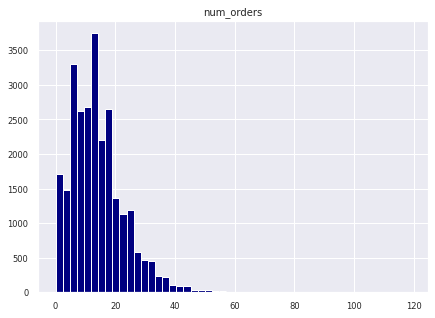

In [8]:
data_info(df_taxi, 7, 5)

### Выводы главы

[К оглавлению](#Оглавление)

**Наименования столбцов:** 
- Наименования корректны, замена наименований не требуется.

**Пропуски данных:** 
Пропуски не обнаружены

**Тип данных и аномальные значения:**

 0.   num_orders int64: тип данных соответствует

<span style='color:blue'> +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ </span>

## Подготовка

In [9]:
#ресемплирование по одному часу
df_taxi.sort_index(inplace=True)
df_taxi_resampled = df_taxi.resample('1H').sum()

<span style='color:blue'> +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ </span>

## Анализ

Проанализируем данные

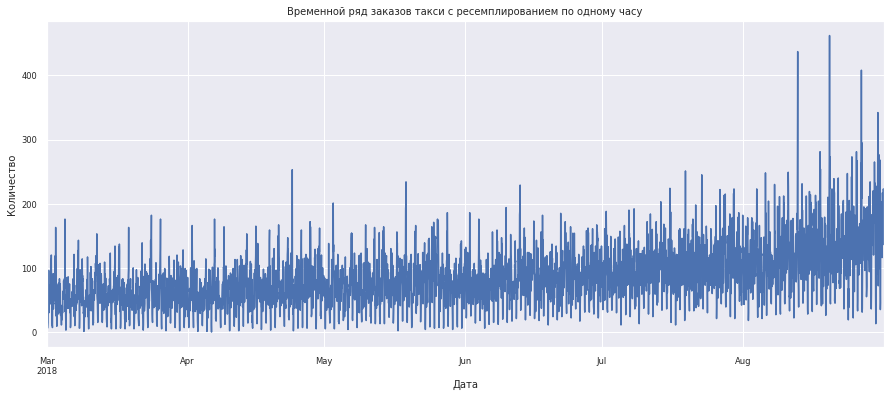

In [10]:
df_taxi_resampled.plot(legend=None)
plt.title('Временной ряд заказов такси с ресемплированием по одному часу')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

In [11]:
df_taxi_resampled['rolling_mean'] = df_taxi_resampled.rolling(10, closed='left').mean() 

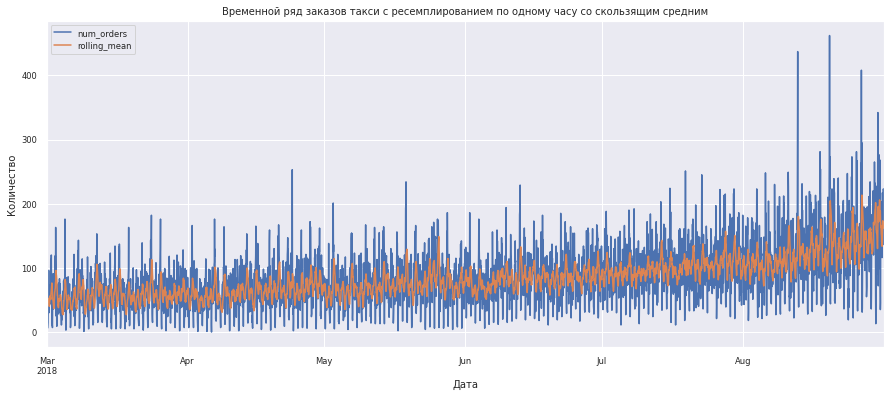

In [12]:
df_taxi_resampled.plot()
plt.title('Временной ряд заказов такси с ресемплированием по одному часу со скользящим средним')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Сделаем срез за месяц (август) 

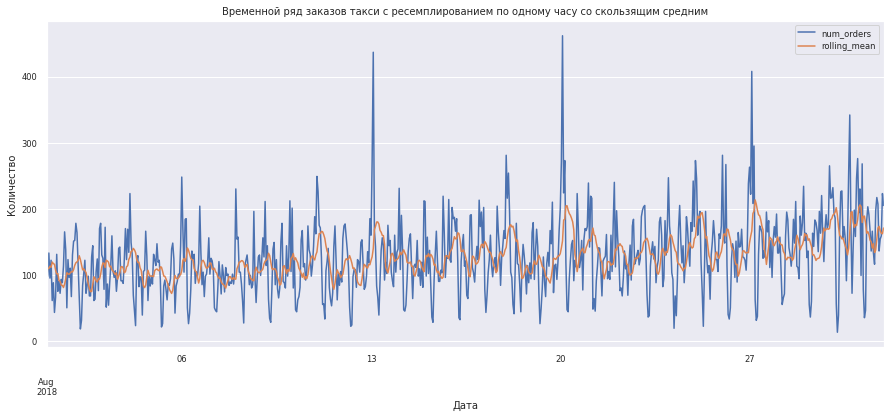

In [13]:
df_taxi_resampled['2018-08-01':'2018-08-31'].plot()
plt.title('Временной ряд заказов такси с ресемплированием по одному часу со скользящим средним')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Сделаем срез за август с ресэмплом по одному дню

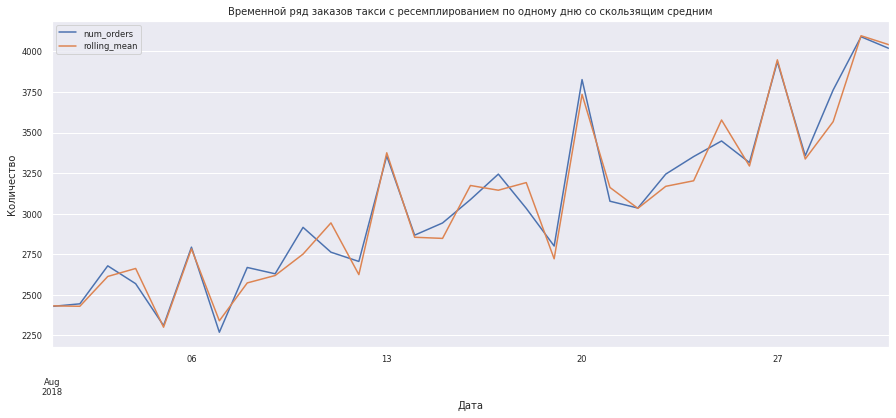

In [14]:
df_taxi_resampled['2018-08-01':'2018-08-31'].resample('1D').sum().plot()
plt.title('Временной ряд заказов такси с ресемплированием по одному дню со скользящим средним')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Сделаем анализ сезоннности и трендов.

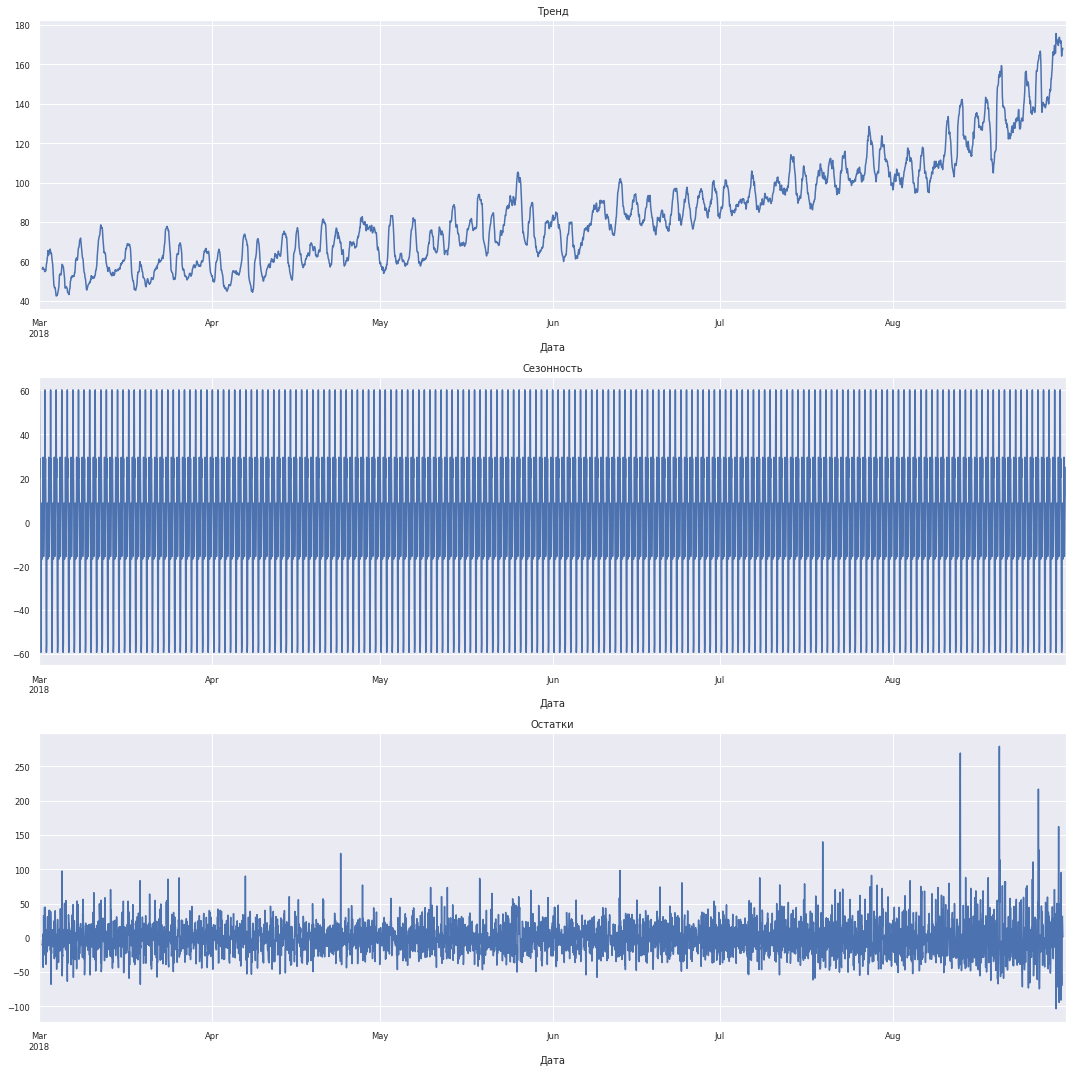

In [15]:
decomposed = seasonal_decompose(df_taxi_resampled['num_orders']) 

plt.figure(figsize=(15, 15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.xlabel('Дата')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.xlabel('Дата')
plt.tight_layout()

Сделаем срез за 15 дней

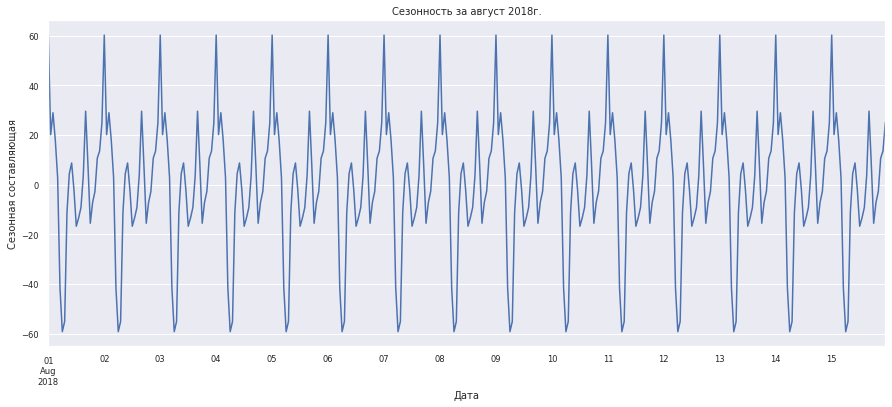

In [16]:
# Сделаем срез компоненты seasonal за первые 15 дней августа 2018 года
seasonal_component = decomposed.seasonal['2018-08-01':'2018-08-15']

# Построим график
plt.figure(figsize=(15, 6))
seasonal_component.plot()
plt.title('Сезонность за август 2018г.')
plt.xlabel('Дата')
plt.ylabel('Сезонная составляющая')
plt.grid(True)
plt.show()

В статистике временной ряд описывается стохастическим процессом (англ. stochastic process). Это случайная величина, у которой со временем меняется её распределение. У этой величины есть среднее и дисперсия, которые тоже меняются.

Стохастический процесс стационарный (англ. stationary stochastic process), если его распределение со временем не меняется. Например, к такому процессу относятся периодические колебания значений.

<Figure size 1080x648 with 0 Axes>

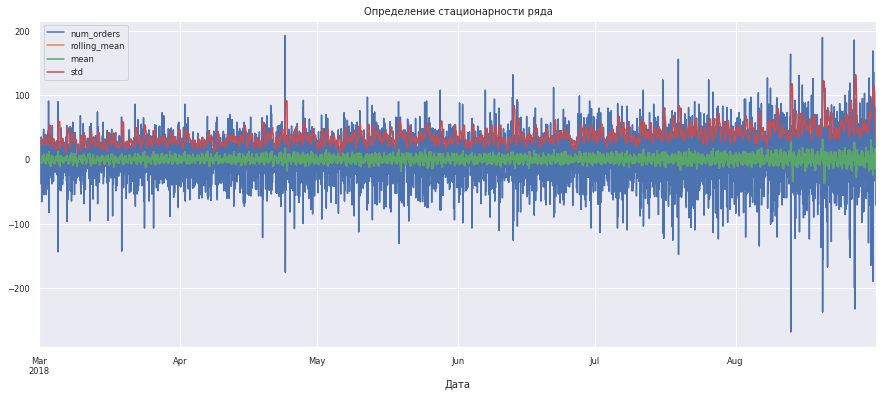

In [17]:
df_taxi_resampled_shifted = df_taxi_resampled - df_taxi_resampled.shift()
df_taxi_resampled_shifted['mean'] = df_taxi_resampled_shifted['num_orders'].rolling(10, closed='left').mean()
df_taxi_resampled_shifted['std'] = df_taxi_resampled_shifted['num_orders'].rolling(10, closed='left').std()
plt.figure(figsize=(15, 9))
df_taxi_resampled_shifted.plot()
plt.title('Определение стационарности ряда')
plt.xlabel('Дата')
plt.show()

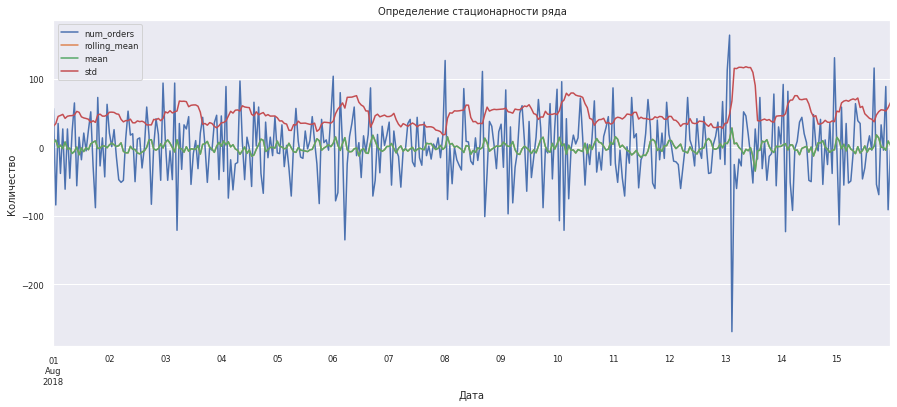

In [18]:
df_taxi_resampled_shifted['2018-08-01':'2018-08-15'].resample('1H').sum().plot()
plt.title('Определение стационарности ряда')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Стационарные временные ряды (англ. stationary time series) — это ряды, у которых среднее и стандартное отклонение не меняются. Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд «более стационарный», чем второй.

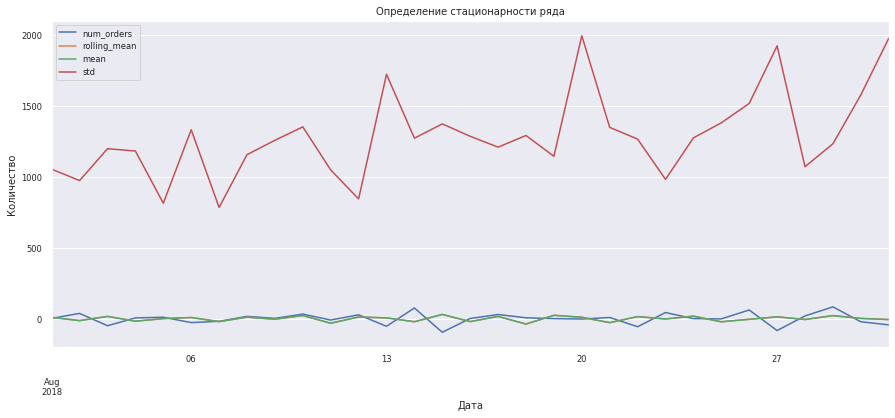

In [19]:
df_taxi_resampled_shifted['2018-08-01':'2018-08-31'].resample('1D').sum().plot()
plt.title('Определение стационарности ряда')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Тест Дики-Фуллера

Один из способов проверить, является ли временной ряд стационарным, — это выполнить расширенный тест Дики-Фуллера , в котором используются следующие нулевая и альтернативная гипотезы:

H 0 : Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

H A : временной ряд является стационарным.

Если p-значение из теста меньше некоторого уровня значимости (например, α = 0,05), то мы можем отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.

In [20]:
di_fu_test = adfuller(df_taxi['num_orders'])

In [21]:
print('ADF статистика:', di_fu_test[0])
print('p-значение:', di_fu_test[1])
print('Критические значения:')
for key, value in di_fu_test[4].items():
    print(f'  {key}: {value}')

ADF статистика: -12.548885000267546
p-значение: 2.2286378815479297e-23
Критические значения:
  1%: -3.430597284562216
  5%: -2.861649292553069
  10%: -2.566828173184574


Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу. Это означает, что временной ряд является стационарным. 

### Выводы главы

[К оглавлению](#Оглавление)

Тест Дики-Фуллера показал, что поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу. Это означает, что временной ряд является стационарным. Однако, проанализировав графики, можно сделать вывод о том тренд явно идёт на увеличение количества заказов, присутствует сезонная составляющая.

<span style='color:blue'> +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ </span>

## Обучение и тестирование моделей

In [22]:
#создание новых признаков
new_features_df_taxi = df_taxi_resampled.copy()
make_features(new_features_df_taxi, 50, 50, 'num_orders')

In [23]:
new_features_df_taxi.dropna(inplace=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    new_features_df_taxi.drop(['num_orders'], axis=1),
    new_features_df_taxi['num_orders'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    shuffle=False)

In [25]:
for name, df in {'X_train' : X_train, 'X_test' : X_test, 'y_train' : y_train, 'y_test' : y_test}.items():
    print(f'Размерность датафрейма {name} : {df.shape}')

Размерность датафрейма X_train : (3929, 53)
Размерность датафрейма X_test : (437, 53)
Размерность датафрейма y_train : (3929,)
Размерность датафрейма y_test : (437,)


In [26]:
# задаём число фолдов для кросс-валидации
tscv = TimeSeriesSplit(n_splits=3) 

In [27]:
num_col = list(new_features_df_taxi)

In [28]:
num_col.remove('num_orders')

In [29]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [30]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', None)
])

Создадим переменную для хранение результатов

In [31]:
results = pd.DataFrame({'model': ['DecisionTreeRegressor', 'CatBoostRegressor', 'XGBoost', 'LinearRegression'],
                        'RMSE_cv_best': ''})

Зададим параметры для моделей

In [32]:
param_grid_0 = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)], 
        'models__max_depth': range(3, 7),
        'models__max_features': range(2, 8),
        # указываем список методов масштабирования  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [33]:
param_grid_1 = [
    {
        'models': [CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)],  # Модель CatBoostRegressor
        'models__iterations': [10, 100, 200],  # Количество итераций обучения
        'models__learning_rate': [0.05, 0.1, 0.2],  # Скорость обучения
        'models__depth': [6, 12, 24]  # Глубина деревьев
    }
]

In [35]:
param_grid_3 = [
    {
        'models': [LinearRegression()],  # LinearRegression
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Обучим модели:

**DecisionTreeRegressor**

In [36]:
randomized_search_0 = RandomizedSearchCV(
    pipe_final, 
    param_grid_0, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [37]:
randomized_search_0.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['rolling_mean',
                                                                                'day',
                                                                                'dayofweek',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10',
                                                                                'lag_11',
                                                                                'lag_12',
                                                                                'lag...
                                                                                'lag_22',
                                                                                'lag_23',
                                                                                'lag_24',
                                                                                'lag_25',
                                                                                'lag_26',
                                                                                'lag_27', ...])])),
                                             ('models', None)]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(3, 7),
                                         'models__max_features': range(2, 8),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [38]:
print('Лучшая модель и её параметры:\n\n', randomized_search_0.best_estimator_)
print ('\nМетрика лучшей модели на кросс-валидации:', - randomized_search_0.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['rolling_mean', 'day',
                                                   'dayofweek', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
                                                   'lag_23', 'lag_24', 'lag_25',
                

CatBoostRegressor

In [39]:
randomized_search_1 = RandomizedSearchCV(
    pipe_final, 
    param_grid_1, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [40]:
randomized_search_1.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['rolling_mean',
                                                                                'day',
                                                                                'dayofweek',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10',
                                                                                'lag_11',
                                                                                'lag_12',
                                                                                'lag...
                                                                                'lag_20',
                                                                                'lag_21',
                                                                                'lag_22',
                                                                                'lag_23',
                                                                                'lag_24',
                                                                                'lag_25',
                                                                                'lag_26',
                                                                                'lag_27', ...])])),
                                             ('models', None)]),
                   n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostRegressor object at 0x7f86b0006400>],
                                         'models__depth': [6, 12, 24],
                                         'models__iterations': [10, 100, 200],
                                         'models__learning_rate': [0.05, 0.1,
                                                                   0.2]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [41]:
print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)
print ('\nМетрика лучшей модели на кросс-валидации:', - randomized_search_1.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['rolling_mean', 'day',
                                                   'dayofweek', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
                                                   'lag_23', 'lag_24', 'lag_25',
             

XGBoost

In [42]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_grid_2, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [43]:
randomized_search_2.fit(X_train, y_train)

[13:37:26] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:37:27] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:37:27] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['rolling_mean',
                                                                                'day',
                                                                                'dayofweek',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10',
                                                                                'lag_11',
                                                                                'lag_12',
                                                                                'lag...
                                                                 n_jobs=None,
                                                                 num_parallel_tree=None,
                                                                 predictor=None,
                                                                 random_state=42,
                                                                 reg_alpha=None,
                                                                 reg_lambda=None,
                                                                 scale_pos_weight=None,
                                                                 subsample=None,
                                                                 tree_method=None,
                                                                 validate_parameters=None,
                                                                 verbose=False,
                                                                 verbosity=None)],
                                         'models__learning_rate': [0.2, 0.4,
                                                                   0.8],
                                         'models__max_depth': [2, 4, 6],
                                         'models__n_estimators': [2, 4, 6]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [44]:
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print ('\nМетрика лучшей модели на кросс-валидации:', - randomized_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['rolling_mean', 'day',
                                                   'dayofweek', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
                                                   'lag_23', 'lag_2...
                       

**LinearRegression**

In [45]:
randomized_search_3 = RandomizedSearchCV(
    pipe_final, 
    param_grid_3, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [46]:
randomized_search_3.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['rolling_mean',
                                                                                'day',
                                                                                'dayofweek',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10',
                                                                                'lag_11',
                                                                                'lag_12',
                                                                                'lag_13',
                                                                                'lag_14',
                                                                                'lag_15',
                                                                                'lag_16',
                                                                                'lag_17',
                                                                                'lag_18',
                                                                                'lag_19',
                                                                                'lag_20',
                                                                                'lag_21',
                                                                                'lag_22',
                                                                                'lag_23',
                                                                                'lag_24',
                                                                                'lag_25',
                                                                                'lag_26',
                                                                                'lag_27', ...])])),
                                             ('models', None)]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring='neg_root_mean_squared_error')

In [47]:
print('Лучшая модель и её параметры:\n\n', randomized_search_3.best_estimator_)
print ('\nМетрика лучшей модели на кросс-валидации:', - randomized_search_3.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['rolling_mean', 'day',
                                                   'dayofweek', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
                                                   'lag_23', 'lag_24', 'lag_25',
             

In [48]:
results.at[0, 'RMSE_cv_best'] = - round(pd.DataFrame(randomized_search_0.cv_results_). \
                                             sort_values(by='rank_test_score').head(1). \
                                             loc[:, ['mean_test_score']].squeeze(), 2)
results.at[1, 'RMSE_cv_best'] = - round(pd.DataFrame(randomized_search_1.cv_results_). \
                                             sort_values(by='rank_test_score').head(1). \
                                             loc[:, ['mean_test_score']].squeeze(), 2)
results.at[2, 'RMSE_cv_best'] = - round(pd.DataFrame(randomized_search_2.cv_results_). \
                                             sort_values(by='rank_test_score').head(1). \
                                             loc[:, ['mean_test_score']].squeeze(), 2)
results.at[3, 'RMSE_cv_best'] = - round(pd.DataFrame(randomized_search_3.cv_results_). \
                                             sort_values(by='rank_test_score').head(1). \
                                             loc[:, ['mean_test_score']].squeeze(), 2)
nice_t(results)

,model,RMSE_cv_best
0,DecisionTreeRegressor,35.020000
1,CatBoostRegressor,25.820000
2,XGBoost,29.210000
3,LinearRegression,25.490000


Проверка на тестовой выборке

DummyRegressor

In [49]:
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train) 
y_test_pred_0 = lm_dummy_mean.predict(X_test) 

In [50]:
print(f'\nМетрика RMSE на тестовой выборке: {round(root_mean_squared_error(y_test_pred_0, y_test), 2)}')


Метрика RMSE на тестовой выборке: 84.76


LinearRegression

In [51]:
y_test_pred_1 = randomized_search_3.best_estimator_.predict(X_test)

In [52]:
print(f'\nМетрика RMSE на тестовой выборке: {round(root_mean_squared_error(y_test_pred_1, y_test), 2)}')


Метрика RMSE на тестовой выборке: 42.03


Построим график предсказаний и тестовой выборки LinearRegression

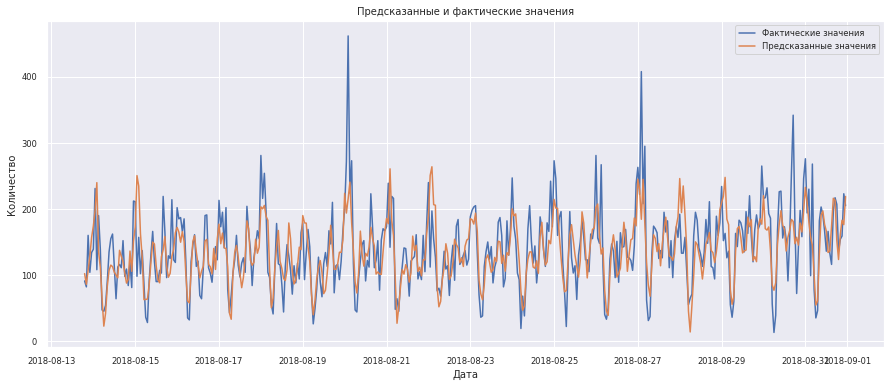

In [53]:
#визуализирую реальные и предсказанные значения тестовой выборки:
fig, ax = plt.subplots()
ax.plot(pd.DataFrame(y_test).index, pd.DataFrame(y_test), label='Фактические значения')
ax.plot(pd.DataFrame(y_test).index, y_test_pred_1, label='Предсказанные значения')
plt.title('Предсказанные и фактические значения')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend()
plt.show()

### Выводы главы

[К оглавлению](#Оглавление)

Наилучшие результаты показала модель LinearRegression с RMSE на тестовой выборке: 42.03
Метрика RMSE DummyRegressor на тестовой выборке: 84.76

Модель неплохо улавливает движение значений, а также даты пиковых показателей нагрузки.
Тем не менее, слишком большие значения, которые выбиваются из общего ряда, модель предсказать не может.

<span style='color:blue'> +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ </span>

## Общий вывод

В рамках работы над проектом должны были достигнуты следующие цели:

- Построена модель для предсказания количества заказов такси

Для достижения целей проекта должны быть выполнены следующие задачи:

1. Исследована общая информация о данных:
    - `taxi.csv`
2. Выполнена предобработка данных:
    - Обработка пропущенных значений (пропущенных значений не обнаружено)
    - Изменение типов данных (типы данных соответствуют)
    - Выявление и обработка аномальных значений (аномальных значений не обнаружено)
3. Загружены данные и выполнено их ресемплирование по одному часу.
4. Данные проанализированы.
    - Тест Дики-Фуллера показал, что поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу. Это означает, что временной ряд является стационарным. Однако, проанализировав графики, можно сделать вывод о том тренд явно идёт на увеличение количества заказов, присутствует сезонная составляющая, ряд нестационарный. 
5. Обучены разные модели с различными гиперпараметрами. Сделана тестовую выборку размером 10% от исходных данных.Данные проверены на тестовой выборке.

    - Наилучшие результаты показала модель LinearRegression с RMSE на тестовой выборке: 42.03. Метрика RMSE DummyRegressor на тестовой выборке: 84.76
    - Модель неплохо улавливает движение значений, а также пиковые показатели нагрузки. Тем не менее, слишком большие значения, которые выбиваются из общего ряда, модель предсказать не может.
